## Exercise 4

## Instructions

- Make sure you have uploaded the audio files to Google Drive if you use colab.
- Please read the markdown sections, and code comments carefully before answering.
- You are required to treat ``...`` as incomplete code, which you are required to complete.
- Each incomplete region marked by ``...`` can be completed with a maximum of 4 statements (4 lines of code in Python). But more elaborate code will not be penalized.
- You may refer to the slides and reference material, but may not use AI code completion or to answer Q&A !!!
- Run all code cells in the notebook even if it does not require any answer from your part.
- The point for each section or sub-section is given in square brackets. E.g [15 pt] means 15 points.
- Pay attention to Q. & A. questions. The markdown-python cell separation is not always obvious.
- **ATTENTION**: There are many places where the path of the audio file needs to be fixed by you.
- Submit the PDF or ipynb that includes all output
- If you are working in groups please mention both your names at the top.
- Do not discuss your results with others outside the group.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
from os import listdir
ex_files = Path("/content/drive/MyDrive/exercise_4")
listdir(ex_files)

['test_files_target_only',
 'test_files',
 'train_files_speaker',
 'test',
 'train',
 'feats']

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
from collections import defaultdict

torch.set_warn_always(False)

In [ ]:
! pip install librosa

## 1. Evaluation of speaker verification systems



In [ ]:
# @title Library function - RUN it, but DO NOT MODIFY
# Copyright of original code belongs to NIST (author: Omid Sadjadi)
# WARNING: This code should not be distributed beyond the scope of this exercise.

def compute_pmiss_pfa_rbst(scores, labels, weights=None):
    """ Computes false positive rate (FPR) and false negative rate (FNR)
    given trial socres and their labels. A weights option is also provided
    to equalize the counts over score partitions (if there is such
    partitioning).

    Args:
        scores: array of all LLR scores (len=S)
        labels: array of {0,1} with 1 denoting target match (len=S)
        weights: array of scalar: {0.0 .. 1.0} (len=S)

    Returns:
        fnr, fpr: tuple of array of fnr/fpr curves (len=S)
    """
    sorted_ndx = np.argsort(scores)
    labels = labels[sorted_ndx]
    if weights is not None:
        weights = weights[sorted_ndx]
    else:
        weights = np.ones((labels.shape), dtype='f8')

    tgt_wghts = weights * (labels == 1).astype('f8')
    imp_wghts = weights * (labels == 0).astype('f8')

    fnr = np.cumsum(tgt_wghts) / np.sum(tgt_wghts)
    fpr = 1 - np.cumsum(imp_wghts) / np.sum(imp_wghts)
    return fnr, fpr


def compute_eer(scores, labels):
    """ Computes the equal error rate (EER) scores and labels.
        for a range of operating points on the DET curve

    Args:
        scores: numpy array of scores
        labels: numpy array of 0s and 1s, one for each value in score. 1 = target, 0 = nontarget

    Returns:
        eer: scalar
    """
    fnr, fpr = compute_pmiss_pfa_rbst(scores, labels)

    diff_pm_fa = fnr - fpr
    x1 = np.flatnonzero(diff_pm_fa >= 0)[0]
    x2 = np.flatnonzero(diff_pm_fa < 0)[-1]
    a = (fnr[x1] - fpr[x1]) / (fpr[x2] - fpr[x1] - (fnr[x2] - fnr[x1]))
    return fnr[x1] + a * (fnr[x2] - fnr[x1])

## Infer Equal Error Rate [5 pt]

Equal error rate is the error rate at which false-alarm rate and miss rate are equal.

1. Look at the DET curve below and estimate the approximate equal error rate from the curve. Explain how you arrived at that number.
  - Approximately 2.5%

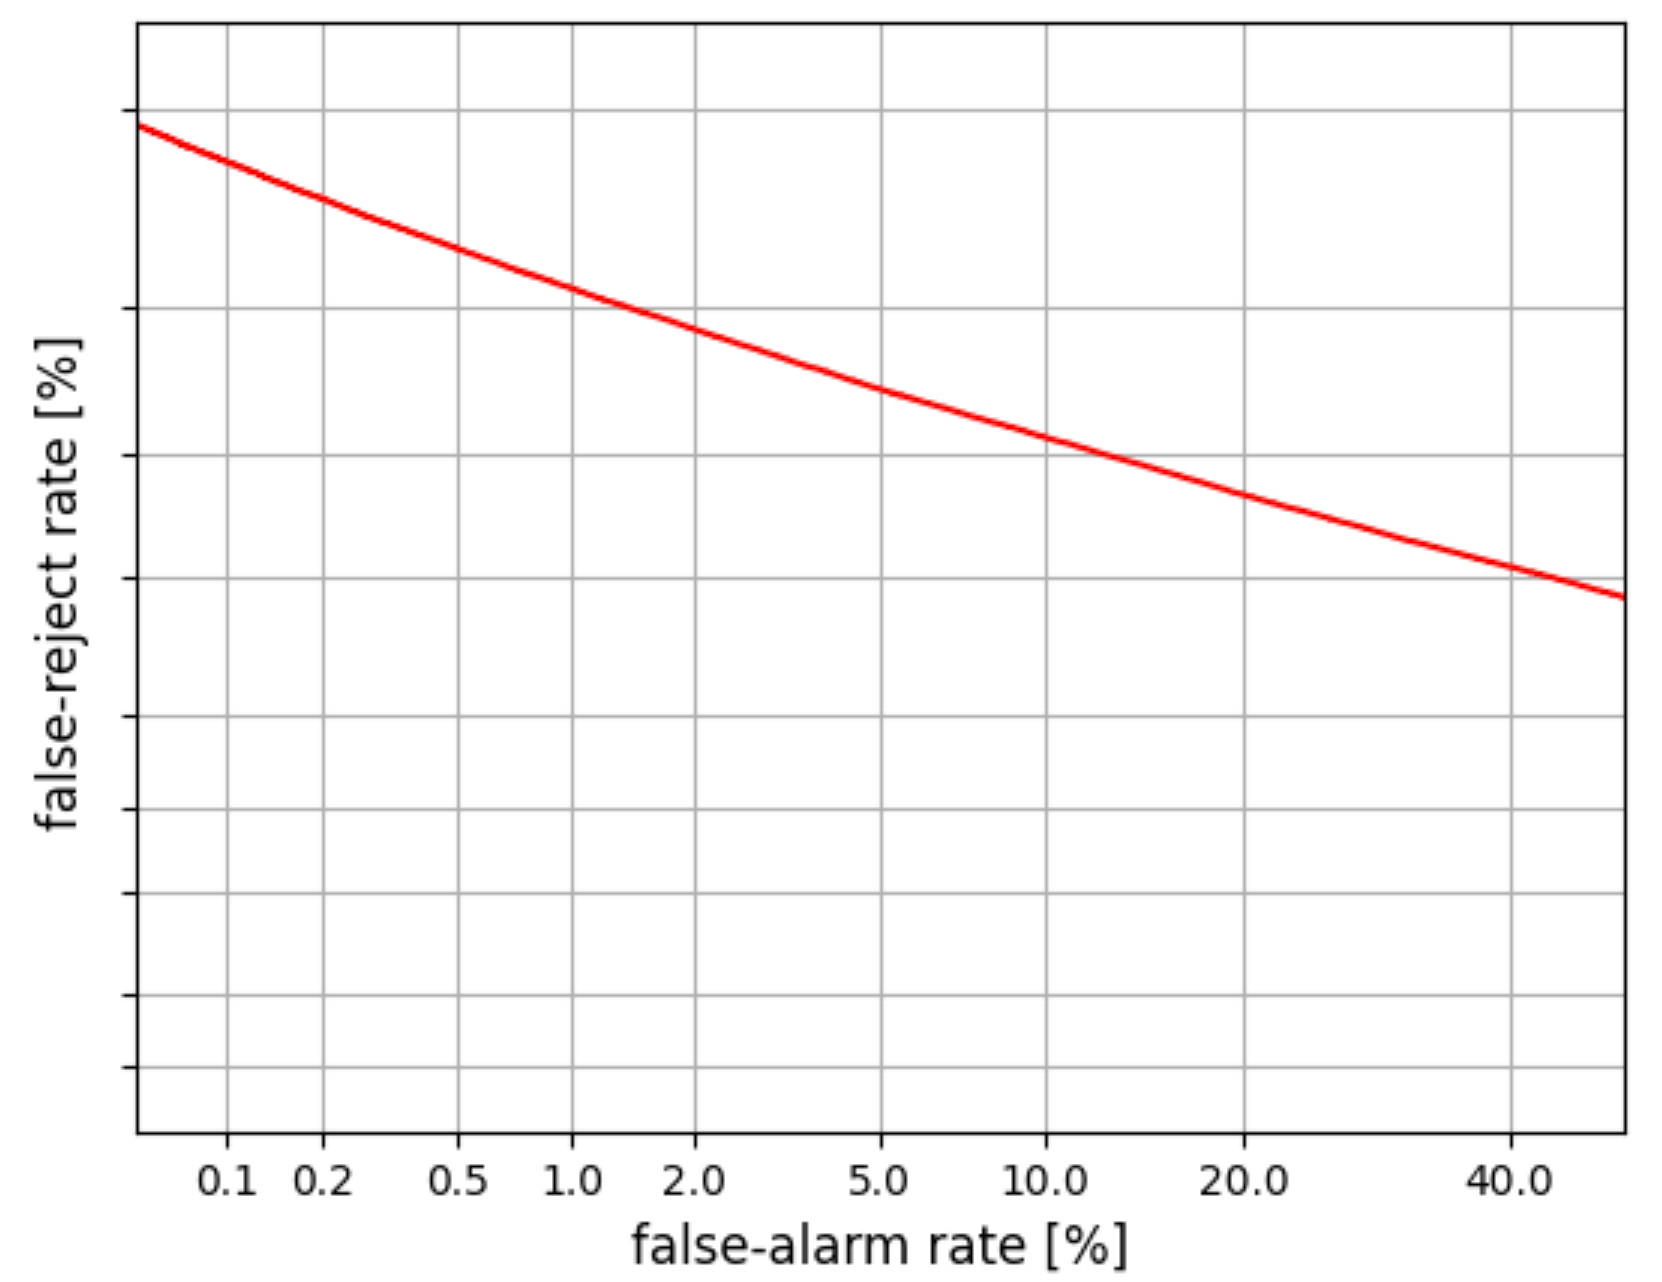



2. Can you infer the threshold used for the speaker verification system to operate at the equal error rate?
  - I would guess it would be the same as the EER mentioned above: so for me it is also 2.5%

## 2. Operating points [5 pt]

The equal error rate is one **operating point** of the system. The operating point is the trade-off between false alarm and miss rate of the system.

1. What happens to the system performance when the operating point is changed?
  - The False positive and/or False negative rate might change

2. What are the characteristics of the operating point for a forensic speaker verification application? Reminder: In forensic speaker verification, we have two speakers (1) unknown speaker (the criminal whose identity we wish to uncover), (2) suspect (known speaker) whose identity we know.
  - Depending on the context (e.g. high stake case) the characteristics have to be tuned. For example accepting a higher miss rate but making sure there are no false positives
  - In a forensic case, we have to make sure that we minimize both error rates
  - operating point should be chosen to maximize the discriminatory power between the criminal (unknown speaker) and the suspect (known speaker)

## Section 3

**NOTE** For this exercise we will process all audio at 8 kHz.

### 3.1 Extract MFCC for all files (5 pt)

There are two folder in ex4_files/audios/

1. train
2. test

For each audio file in the audio/ folder, pre-compute the 20 dimensional MFCC features at 20 ms window size, 10 ms shift and store them in ``ex_files``/feats/. Preserve the directory structure (otherwise you will have to modify a lot of code below).

For MFCC extraction you may reuse the code from previous exercise.

In [ ]:
feats_path = ex_files/'feats'  # Modify this path accordingly
feats_path.mkdir(exist_ok=True)

feats_train_path = feats_path/'train'
feats_test_path = feats_path/'test'
feats_train_path.mkdir(exist_ok=True)
feats_test_path.mkdir(exist_ok=True)

listdir(feats_path)

['train', 'test']

In [ ]:
# ENTER your code here.
import os
import librosa
import torch
from pathlib import Path
import soundfile as sf

def extract_mfcc(audio_file, sr=8000, n_mfcc=20, win_length=0.02, hop_length=0.01):
    audio, sr = librosa.load(audio_file, sr=sr)

    win_length_samples = int(win_length * sr)
    hop_length_samples = int(hop_length * sr)

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, win_length=win_length_samples, hop_length=hop_length_samples)

    return mfcc.T


test_folder = ex_files/"test"
for audio_file in test_folder.rglob("*.wav"):
    relative_path = audio_file.relative_to(test_folder)
    target_file = feats_test_path / relative_path.with_suffix(".pt")

    target_file.parent.mkdir(parents=True, exist_ok=True)

    try:
        mfcc = extract_mfcc(audio_file)
        mfcc_tensor = torch.from_numpy(mfcc).float()
        torch.save(mfcc_tensor, target_file)
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

# Save MFCC as tensors for train set
train_folder = ex_files/"train"
for audio_file in train_folder.rglob("*.wav"):
    relative_path = audio_file.relative_to(train_folder)
    target_file = feats_train_path / relative_path.with_suffix(".pt")

    target_file.parent.mkdir(parents=True, exist_ok=True)

    try:
        mfcc = extract_mfcc(audio_file)
        mfcc_tensor = torch.from_numpy(mfcc).float()
        torch.save(mfcc_tensor, target_file)
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")





In [ ]:
print(listdir(ex_files/'feats'/"train"))

print(listdir(ex_files/'feats'/"test"))

['fejen_2.pt', 'ffjmb_1.pt', 'fggft_2.pt', 'ffyep_1.pt', 'faawn_1.pt', 'febwp_1.pt', 'fcavm_1.pt', 'ffapq_2.pt', 'fbgst_1.pt', 'fhplc_1.pt', 'faicw_1.pt', 'faijj_2.pt', 'fakzi_1.pt', 'fhfth_2.pt', 'fdhli_1.pt', 'fexfq_2.pt', 'fhehc_1.pt', 'fgwgq_2.pt', 'fctne_2.pt', 'fcnzb_1.pt', 'fdhlr_2.pt', 'fkybg_2.pt', 'fkbni_2.pt', 'fkxse_2.pt', 'fjgru_2.pt', 'firex_1.pt', 'fjume_1.pt', 'fkffd_2.pt', 'flbde_1.pt', 'flqne_2.pt', 'fmexw_1.pt', 'flvxz_1.pt', 'fitrd_2.pt', 'fjejo_2.pt', 'fldzi_2.pt', 'fkujc_1.pt', 'flkda_1.pt', 'fkvsd_2.pt', 'fmeen_2.pt', 'fnori_2.pt', 'fuegj_2.pt', 'fxzpb_2.pt', 'fntna_1.pt', 'fqerb_1.pt', 'fxhku_1.pt', 'frknb_1.pt', 'foqcd_2.pt', 'fabax_2.pt', 'fmvse_1.pt', 'fzmaa_2.pt', 'fnfwv_2.pt', 'fmjqf_2.pt', 'fzejw_1.pt', 'fygzg_2.pt', 'fpdac_2.pt', 'fqqvt_2.pt', 'fxtty_1.pt', 'fulzs_2.pt', 'fuscd_1.pt', 'fphqz_2.pt', 'fyqem_1.pt', 'fyxsa_1.pt', 'folgy_2.pt', 'fuvlb_1.pt', 'fnfwl_2.pt', 'fziza_1.pt', 'fpiuo_2.pt', 'fstaq_1.pt', 'fanvz_2.pt', 'fbgsv_2.pt', 'fajim_2.pt', 'fboj

## 3.2 GMM based speaker identification (again)

### 3.2.1 Listening exercise (5 pt)

Listen to some of the audios in the current exercise. Do the same for a random set of audio files used for GMM training in the previous exercise. Describe any noticeable differences in the dataset.
  - The random ones i picked out in exercise 4 were much longer in duration than the ones from e.g exercise 3
  - Audioquality-wise both seemed to be about the same
  - I could listen to all I chose of in exercise 4 but for the ones in exercise 3 google drive wouldnt let me listen to them after a while

### 3.2.2 Train GMM for target speakers (10 pt)

We now have two text files of relevance to this part of the exercise:

1. ``train_files_speaker``: it is a two column file. Column one contains the identity of the speaker. Column two contains the file to be used for enrollment. Note that column one entries are not unique. That is, each speaker may have more than one file for enrollment. Similar to the previous exercise, you will have to combine them to train one GMM.
2. ``test_files_target_only``: The list of test files we will be using to evaluate the GMM models. Again, it is a two column file. The first column is the name of the test file to process and the second column is the true id of the speaker.

In [ ]:
from collections import defaultdict

spkr2enroll_files = defaultdict(list)  # this variable is to be used during training
enroll2spkr_id = {}  # this variable is to be used during evaluation

with open(ex_files/'train_files_speaker') as ipf:
    for ln in ipf:
        lns = ln.strip().split()
        spkr2enroll_files[lns[0]].append(lns[1])
        enroll2spkr_id[lns[1]] = lns[0]

In [ ]:
test_files = []
spkr_id = []
test_file2spk_id = {}

with open(ex_files/'test_files_target_only') as ipf:
    for ln in ipf:
        t, s = ln.strip().split()
        test_files.append(t)
        spkr_id.append(s)
        test_file2spk_id[t] = s

In [ ]:
from sklearn.mixture import GaussianMixture
import os

spkr2gmm = {}
feats_path = ex_files/"feats"/"train"

for spkr, enroll_files in spkr2enroll_files.items():
    all_mfccs = []

    # load pre-computed mfccs
    for segment in enroll_files:
        mfcc_file = os.path.join(feats_path, segment + '.pt')
        mfcc_tensor = torch.load(mfcc_file)

        mfcc = mfcc_tensor.numpy()
        all_mfccs.append(mfcc)
    all_mfccs = np.vstack(all_mfccs)

    gmm = GaussianMixture(n_components=16)
    gmm.fit(all_mfccs)

    spkr2gmm[spkr] = gmm


<ipython-input-13-3fd8527bee4b>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mfcc_tensor = torch.load(mfcc_file)
<ipython-input-13-3fd8527bee4b>:13: FutureWarning: You 

In [ ]:
# For each test file, calculate the log-likelihood of the test file given each speaker's GMM
feats_path_test = ex_files / "feats" / "test"

n_correct = 0
total = len(test_files)
for test_file, test_spkr in zip(test_files, spkr_id):
    test_mfcc_file = os.path.join(feats_path_test, test_file + '.pt')
    test_mfcc_tensor = torch.load(test_mfcc_file)
    test_mfcc = test_mfcc_tensor.numpy()

    scores, labels = [], []
    for spkr, gmm in spkr2gmm.items():
        score = gmm.score(test_mfcc)
        scores.append(score)

        labels.append(0 if spkr != test_spkr else 1)

    n_correct += labels[np.argmax(scores)]

print("Accuracy: {:.2f}%".format(n_correct * 100.0 / total))

<ipython-input-17-4267f06e7c16>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_mfcc_tensor = torch.load(test_mfcc_file)
<ipython-input-17-4267f06e7c16>:8: FutureWarni

Accuracy: 72.34%


1. Conclude which setup ("number of mixtures" of the GMM) works best.
  - After testing different setups (numbers of mixtures), the configuration that results in the lowest EER is considered the best model setup.

2. Is the number of mixtures different from that used in the previous exercise for speaker identification on a different dataset. Hypothesize why it is the same (or not)?

## 3.2.3 Channel compensation (10 pt)

A common method to reduce mismatch in channel conditions (changes in recording conditions such as recording equipment, environment of recording, recording format, etc.) is to enforce the statistics of the data to have zero mean and unit variance. This is achieved by standardization of the input features: remove the mean of the features and divide by standard deviation.

This operation is done dimension-wise over the feature dimension. For each dimension in the input sequence of feature vectors, the standardization is applied independent of other dimensions. The mean is computed for each dimension $d = 1 \dots D$  (D=20 for MFCCs in our case), and all values of the $d^{\text{th}}$ feature dimension are subtracted with the mean value computed over the training data for that sequence and divided by the standard deviation.

In this part of the exercise, we will demonstrate the effectiveness of this procedure to improve the performance of our system.

Implement this using built-in tensor member functions of the input tensor.

In [ ]:
def cepstral_mean_and_variance_normalization(mfcc: torch.Tensor):
    """Returns standardized features

    mfcc is expected to be a 2D tensor with dimension TxD where T is the
    number of frames in audio and D is the dimensionality one feature vector.
    """
    mean = mfcc.mean(dim=0, keepdim=True)
    std = mfcc.std(dim=0, keepdim=True)

    mfcc_cmvn = (mfcc - mean) / std
    return mfcc_cmvn

Now check the performance of the GMM system by applying the ``cepstral_mean_and_variance_normalization`` on MFCC features:

1. During training only, but not testing
  - leads to a mismatch between training and testing data distributions, as the model learns from normalized features but tests on raw, unnormalized ones. Can result in poor performance during testing
2. During training and testing
  - ensures consistency and helps improve model performance.
3. During testing only, but not training
  - while training on raw features causes a mismatch between the feature distributions seen during training and testing, leading to performance degradation.

Explain the results.

You may want to think if it is necessary to retrain the model if the mean & variance normalization is applied.

## Section 4: Neural network based speaker recognition



## 4.1 TDNN code

In this section of the exercise, we define the basic component of a neural network based speaker verification system. In the class we saw Time Delay Neural Network that help capture patterns over a given context. In the proceeding cells, we will use Pytorch to define a TDNN module that can be reused in the Xvector model architecture.

In [ ]:
# DO NOT MODIFY
# Apache License, Version 2.0  (author: Srikanth Madikeri, 2020, 2024)

import torch.nn as nn
import torch.nn.functional as F

class TDNN(nn.Module):
    def __init__(
        self,
        feat_dim,
        output_dim,
        context_len=1,
    ):
        super(TDNN, self).__init__()
        self.linear = nn.Linear(feat_dim*context_len, output_dim)
        self.context_len = torch.tensor(context_len, requires_grad=False)


    def forward(self, input):
        mb, T, D = input.shape
        padded_input = input.reshape(mb, -1).unfold(1, D*self.context_len, D).contiguous()
        x = self.linear(padded_input)
        return x


class TDNNBatchNorm(nn.Module):
    def __init__(
        self,
        feat_dim,
        output_dim,
        context_len=1,
    ):
        super(TDNNBatchNorm, self).__init__()
        self.tdnn = TDNN(
            feat_dim,
            output_dim,
            context_len=context_len,
        )
        self.bn = nn.BatchNorm1d(output_dim, affine=False)

    def forward(self, input):
        mb, T, D = input.shape
        x = self.tdnn(input)
        x = F.relu(x)
        x = x.permute(0, 2, 1)
        x = self.bn(x)
        x = x.permute(0, 2, 1)
        return x

### 4.2 Complete the code (10 pt)

In [ ]:
# Copyright     University of Zurich (author: Srikanth Madikeri)
# License: Apache 2.0

class Xvector(nn.Module):
    def __init__(self, feat_dim, n_target_speakers, n_layers=1, hidden_dim=32, contexts=[1]):
        """
        Args:
            feat_dim: int, input feature dimension
            n_target_speakers: int, number of target speakers
            n_layers: int, number of TDNN layers (default: 1)
            hidden_dim: int, hidden dimension of TDNN layers (default: 32)
            contexts: list of int, context length of TDNN layers. E.g. [5,2] if the first layer has a context of 5 and the second layer has a context of 2
        """
        super(Xvector, self).__init__()
        assert n_layers == len(contexts), "n_layers must be equal to the length of contexts"
        self.tdnn1 = TDNNBatchNorm(feat_dim, hidden_dim, context_len=contexts[0])
        # from the 2nd layer, the input and output dim are the same for
        # each layer
        if n_layers > 1:
            self.tdnn2_module_list = nn.ModuleList(
                [
                    TDNNBatchNorm(hidden_dim, hidden_dim, context_len=context)
                    for context in contexts[1:]
                ]
            )
        else:
            self.tdnn2_module_list = []
        self.linear1 = nn.Linear(2*hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, n_target_speakers)
        self.bn = nn.BatchNorm1d(hidden_dim, affine=False)

    def forward(self, input, x_lens):
        x = F.layer_norm(input, normalized_shape=[input.shape[-1]])
        x = self.tdnn1(input)
        if self.tdnn2_module_list:
            for tdnn in self.tdnn2_module_list:
                x = tdnn(x)
        mean_pooling = x.sum(dim=1) / x_lens[:, None]
        var_pooling = ((x**2).sum(dim=1) - mean_pooling**2) / x_lens[:, None]
        std_pooling = var_pooling.sqrt()
        stats_pool = torch.cat([mean_pooling, std_pooling], dim=1)
        x = self.linear1(stats_pool)
        x = F.relu(x)
        x = self.bn(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    # Complete this function to get embedding from the model
    def get_embedding(self, input, x_lens):
        # obtain speaker embeddings from the model instead of the output from
        # the final layer of the model. Choose the appropriate layer to obtain the
        # speaker embedding.
        # Normalize the input features
        x = F.layer_norm(input, normalized_shape=[input.shape[-1]])

        # Pass the input through the TDNN layers
        x = self.tdnn1(input)
        if self.tdnn2_module_list:
            for tdnn in self.tdnn2_module_list:
                x = tdnn(x)

        # Apply mean and standard deviation pooling
        mean_pooling = x.sum(dim=1) / x_lens[:, None]
        var_pooling = ((x**2).sum(dim=1) - mean_pooling**2) / x_lens[:, None]
        std_pooling = var_pooling.sqrt()
        stats_pool = torch.cat([mean_pooling, std_pooling], dim=1)

        # The speaker embedding is typically extracted here before classification
        embedding = stats_pool

        return embedding


1. Is the above definition of Xvector class the same as what we saw discussed in the class? Justify your answer. (3 pt)

2. Complete the ``get_embedding`` function to obtain the speaker embeddings. Justify your implementation.  (5 pt)
  - The get_embedding function extracts a fixed-size speaker embedding from the input sequence by normalizing the features and passing them through TDNN layers
  - Mean and standard deviation pooling is applied to summarize the speaker's characteristics

3. Identify the part of the code that differentiates the above model from a TDNN based architecture for any other speech processing task. (2 pt)
  - main difference in the Xvector model is the mean and standard deviation pooling
  - Xvector generates a fixed-size embedding for the entire sequence
  - final output in Xvector is the embedding, not class predictions

## 4.3 Run the code below with default parameters (5pt)

In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, feats_path, spkr2enroll_files, spkr2idx):
        self.feats_path = feats_path
        self.spkr2enroll_files = spkr2enroll_files
        self.spkr2idx = spkr2idx
        self.data = []

        for spkr, enroll_files in spkr2enroll_files.items():
            for segment in enroll_files:
                mfcc_file = os.path.join(feats_path, segment + '.pt')
                mfcc_tensor = torch.load(mfcc_file)
                label = self.spkr2idx[spkr]
                self.data.append((mfcc_tensor, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
# Nothing to do in this sell. Just run it.
dataset = TrainDataset(feats_train_path, spkr2enroll_files, spkr2idx)

def collate_fn(batch):
    # pad sequences to the same length
    max_len = max([item[0].shape[0] for item in batch])
    data = [F.pad(item[0], (0, 0, 0, max_len-item[0].shape[0])) for item in batch]
    x_lens = [item[0].shape[0] for item in batch]
    labels = [item[1] for item in batch]
    return torch.stack(data), torch.tensor(labels), torch.tensor(x_lens)

<ipython-input-33-4ed46a5160b7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mfcc_tensor = torch.load(mfcc_file)


In [ ]:
# This is a generic training setup that you can reuse for the next parts of the exercises.

torch.manual_seed(42)  # do not change this line. It makes it easier to verify your results.

model = Xvector(20, len(spkr2enroll_files))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.NLLLoss(reduction='sum')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

train_loss = []
n_epochs = 50
for epoch in range(50):
    for i, (data, labels, x_lens) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data, x_lens)
        loss = criterion(output, labels)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        # lrscheduler.step()
        if i % 10 == 0:
            print(f'Epoch {epoch}, batch {i}, loss: {loss.item()/data.shape[0]}')

Epoch 0, batch 0, loss: 3.584404468536377
Epoch 0, batch 10, loss: 3.741875171661377
Epoch 0, batch 20, loss: 3.830500602722168
Epoch 1, batch 0, loss: 3.7391233444213867
Epoch 1, batch 10, loss: 3.6074938774108887
Epoch 1, batch 20, loss: 3.7987146377563477
Epoch 2, batch 0, loss: 3.6076462268829346
Epoch 2, batch 10, loss: 3.7440590858459473
Epoch 2, batch 20, loss: 3.5461041927337646
Epoch 3, batch 0, loss: 3.93996262550354
Epoch 3, batch 10, loss: 3.9643962383270264
Epoch 3, batch 20, loss: 3.9218175411224365
Epoch 4, batch 0, loss: 3.89355206489563
Epoch 4, batch 10, loss: 3.482002019882202
Epoch 4, batch 20, loss: 3.6247236728668213
Epoch 5, batch 0, loss: 3.4632325172424316
Epoch 5, batch 10, loss: 3.702068328857422
Epoch 5, batch 20, loss: 3.517760753631592
Epoch 6, batch 0, loss: 3.4876651763916016
Epoch 6, batch 10, loss: 3.7665257453918457
Epoch 6, batch 20, loss: 3.7112364768981934
Epoch 7, batch 0, loss: 3.676969528198242
Epoch 7, batch 10, loss: 3.2386584281921387
Epoch 7

## 4.4 Xvector training (15 pt)

In this section, we will train a model with the following architecture: 3 layers with the context of 3 frames for each layer.

1. In the subsequent code cells, instantiate three different xvector models. Each Xvector model differs in the hidden dimension: 32, 64 and 128. Obtain the accuracy for each model. Name each model carefully (e.g. model_32d, model_64d, ...) in order to be able to differentiate the results easily. Justify the results obtained.

2. Identify flaw(s) if any with our experimental setup for speaker identification system for 44 speakers? Justify your answer.
  - Model with 32 hidden dimensions: Likely to be faster to train and less prone to overfitting but might struggle to capture the complexity of the data, especially with 44 speakers.
  - Model with 64 hidden dimensions: Should strike a balance between model  
  capacity and generalization. It may offer better performance than the 32-dimensional model without overfitting too much.
 - Model with 128 hidden dimensions: Likely to perform the best in terms of accuracy but at the risk of overfitting. This model will require more data to train effectively and generalize well.

In [ ]:
# You may reuse any code done in earlier part of the experiment.
#class Xvector(nn.Module):
#    def __init__(self, feat_dim, n_target_speakers, n_layers=1, hidden_dim=32, contexts=[1]):

#class TrainDataset(torch.utils.data.Dataset):
#    def __init__(self, feats_path, spkr2enroll_files, spkr2idx):

#dataset = TrainDataset(feats_train_path, spkr2enroll_files, spkr2idx)

def calculate_accuracy(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for data, labels, x_lens in dataloader:
            output = model(data, x_lens)
            _, predicted = torch.max(output, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
    accuracy = correct_preds / total_preds * 100.0
    return accuracy

model_32 = Xvector(20, len(spkr2enroll_files), hidden_dim=32, contexts=[3])
model_64 = Xvector(20, len(spkr2enroll_files), hidden_dim=64, contexts=[3])
model_128 = Xvector(20, len(spkr2enroll_files), hidden_dim=128, contexts=[3])

optimizer_32 = torch.optim.Adam(model_32.parameters(), lr=0.0003)
optimizer_64 = torch.optim.Adam(model_64.parameters(), lr=0.0003)
optimizer_128 = torch.optim.Adam(model_128.parameters(), lr=0.0003)

criterion = nn.NLLLoss(reduction='sum')

dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

train_loss_32 = []
accuracies_32 = []
for epoch in range(50):
    model_32.train()
    for i, (data, labels, x_lens) in enumerate(dataloader):
        optimizer_32.zero_grad()
        output = model_32(data, x_lens)
        loss = criterion(output, labels)
        train_loss_32.append(loss.item())
        loss.backward()
        optimizer_32.step()

    accuracy_32 = calculate_accuracy(model_32, dataloader)
    accuracies_32.append(accuracy_32)

train_loss_64 = []
accuracies_64 = []
for epoch in range(50):
    model_64.train()
    for i, (data, labels, x_lens) in enumerate(dataloader):
        optimizer_64.zero_grad()
        output = model_64(data, x_lens)
        loss = criterion(output, labels)
        train_loss_64.append(loss.item())
        loss.backward()
        optimizer_64.step()

    accuracy_64 = calculate_accuracy(model_64, dataloader)
    accuracies_64.append(accuracy_64)

train_loss_128 = []
accuracies_128 = []
for epoch in range(50):
    model_128.train()
    for i, (data, labels, x_lens) in enumerate(dataloader):
        optimizer_128.zero_grad()
        output = model_128(data, x_lens)
        loss = criterion(output, labels)
        train_loss_128.append(loss.item())
        loss.backward()
        optimizer_128.step()

    accuracy_128 = calculate_accuracy(model_128, dataloader)
    accuracies_128.append(accuracy_128)

print("\nFinal Accuracies:")
print(f"Model_32 final accuracy: {accuracies_32[-1]:.2f}%")
print(f"Model_64 final accuracy: {accuracies_64[-1]:.2f}%")
print(f"Model_128 final accuracy: {accuracies_128[-1]:.2f}%")






Final Accuracies:
Model_32 final accuracy: 59.80%
Model_64 final accuracy: 85.78%
Model_128 final accuracy: 96.57%


### 4.5 Speaker verification with Xvector embeddings (10 pt)

 Now we have a model. For "every" audio file in ``feats/train`` and ``feats/test`` extract an embedding. In the case of test folder,
you will have 20 more files than that used for speaker identification so far.


In [ ]:
model.eval()  # DO NOT remove this.

Xvector(
  (tdnn1): TDNNBatchNorm(
    (tdnn): TDNN(
      (linear): Linear(in_features=60, out_features=32, bias=True)
    )
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (tdnn2_module_list): ModuleList(
    (0-1): 2 x TDNNBatchNorm(
      (tdnn): TDNN(
        (linear): Linear(in_features=96, out_features=32, bias=True)
      )
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=44, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [ ]:
test_files_set = set(test_files)
with open(ex_files/'test_files') as ipf:
    new_test_files = [ln.strip() for ln in ipf if ln.strip() not in test_files_set]

new_test_files_set = set(new_test_files)

In [ ]:
assert len(new_test_files) == 20, "test_files or test_files_target_only is not correct. Please verify"

In [ ]:
# extract embeddings for enrollment files
enroll_file2embedding = {}
for spkr, enroll_files in spkr2enroll_files.items():
    all_mfccs = []
    for segment in enroll_files:
        mfcc_file = os.path.join(ex_files, 'feats', 'train', segment + '.pt')
        mfcc_tensor = torch.load(mfcc_file)

        mfcc_tensor = mfcc_tensor.unsqueeze(0)
        x_lens = torch.tensor([mfcc_tensor.shape[1]])

        embedding = model.get_embedding(mfcc_tensor, x_lens)
        enroll_file2embedding[segment] = embedding

<ipython-input-44-70a8cc732b49>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mfcc_tensor = torch.load(mfcc_file)


In [ ]:
test_file2embedding = {}
# for each .pt file in feats/test/:
for test_name in test_files + new_test_files:
    est_mfcc_file = os.path.join(ex_files, 'feats', 'test', test_name + '.pt')
    test_mfcc_tensor = torch.load(test_mfcc_file)

    test_mfcc_tensor = test_mfcc_tensor.unsqueeze(0)
    x_lens = torch.tensor([test_mfcc_tensor.shape[1]])

    embedding = model.get_embedding(test_mfcc_tensor, x_lens)

    test_file2embedding[test_name] = embedding

<ipython-input-46-6f4330e7f393>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_mfcc_tensor = torch.load(test_mfcc_file)


In [ ]:
target_scores = []
non_target_scores = []

for test_file, test_embedding in test_file2embedding.items():
    test_embedding = test_embedding.squeeze()
    for enroll_file, enroll_embedding in enroll_file2embedding.items():
        enroll_embedding = enroll_embedding.squeeze().cpu()

        score = F.cosine_similarity(test_embedding.unsqueeze(0), enroll_embedding.unsqueeze(0))

        if test_file in test_files_set and enroll2spkr_id[enroll_file] == test_file2spk_id[test_file]:
            target_scores.append(score.item())
        else:
            non_target_scores.append(score.item())

print(f"Number of target scores: {len(target_scores)}")
print(f"Number of non-target scores: {len(non_target_scores)}")


Number of target scores: 235
Number of non-target scores: 13433


In [ ]:
# compute eer
scores = np.array(target_scores + non_target_scores)
labels = [1]*len(target_scores) + [0]*len(non_target_scores)
labels = np.array(labels)
assert scores.shape == labels.shape, "The number of scores and labels should be the same"
eer = compute_eer(scores, labels)
print("Equal error rate ", eer*100.0)

Equal error rate  50.638297872340424


## 5. Embeddings from a pretrained model (10 pt)

In this part of the exercise, we will use a pretrained model. This is a model trained with large amounts of data collected and annotated from YouTube recording. The objective of this exercise is to

1. practice using open source models for speaker recognition tasks
2. realise the ease with which we can reuse publicly available models.
3. understand the power of generalizability of speaker emebddings extracted from models trained with large amounts of data on unseen data

We will use a model based on the [ECAPA-TDNN architecture](https://arxiv.org/pdf/2005.07143) (not discussed in the class, but it is not required to understand the architecture to run this exercise). The model was trained with the speechbrain toolkit using only one dataset: the VoxCeleb dataset which consists of 1000s of celebrity speakers. It takes 16 kHz audio as input.

In [ ]:
! pip install speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 38.1 MB/s eta 0:00:00


In [ ]:
# To extract embedding from the ecapa-tdnn
import torchaudio
from speechbrain.inference.speaker import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [ ]:
# Modify any part if necessary
import torchaudio

enroll_file2embedding = {}
enroll2spkr_id = {}
for spkr, enroll_files in spkr2enroll_files.items():
    all_mfccs = []
    for segment in enroll_files:
        audio_path = os.path.join("/content/drive/MyDrive/exercise_4/train", segment + '.wav')
        audio_samples, sample_rate = torchaudio.load(audio_path)

        if sample_rate != 16000:
            audio_samples = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(audio_samples)

        embedding = classifier.encode_batch(audio_samples)

        enroll_file2embedding[segment] = embedding.squeeze(0)
        enroll2spkr_id[segment] = spkr



In [ ]:
test_file2embedding = {}

for test_name in test_files + new_test_files:
    audio_path = os.path.join("/content/drive/MyDrive/exercise_4/test", test_name + '.wav')
    audio_samples, sample_rate = torchaudio.load(audio_path)

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        audio_samples = resampler(audio_samples)

    embedding = classifier.encode_batch(audio_samples)

    test_file2embedding[test_name] = embedding


In [ ]:
# Compute target, non-target scores, eer and print eer (reuse code from Section .5)
# compute eer
scores = np.array(target_scores + non_target_scores)
labels = [1]*len(target_scores) + [0]*len(non_target_scores)
labels = np.array(labels)
assert scores.shape == labels.shape, "The number of scores and labels should be the same"
eer = compute_eer(scores, labels)
print("Equal error rate ", eer*100.0)

Equal error rate  50.638297872340424


Write down your observation and conclusion comparing the above results with the results from Section 4.5 (maximum of 3 sentences).

## Closing questions about automatic speaker recognition (10 pt)

Keep your answers brief (3 sentences maximum).

1. What are the phases of system development for neural network based speaker verification system? (2pt)
  - Data collection and preprocessing.
  - Model training and evaluation.
  - Deployment and monitoring.

2. Given a collection of recordings what metadata is required to train a neural network based speaker identification system? (2pt)
  - Speaker ID, recording timestamp, microphone/environment details, gender/age, language spoken.

3. How can we convert parameters of a GMM model trained in this notebook into embeddings for speaker verification instead of using the scoring function? Justify your response. (6 pt)
  - Extract the means and covariances from the trained GMM and use them as feature vectors.
  - These vectors can represent speaker characteristics, providing a lower-dimensional embedding.
  - This approach eliminates the need for scoring functions by directly using the GMM's statistical properties to represent speaker identity.